# LinearRegression Sklearn

## 1. 保序回归（Isotonic Regression）

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.utils import check_random_state

In [28]:
n = 100
x = np.arange(n)
rs = check_random_state(0)
y = rs.randint(-50, 50, size=(n,)) + 50. * np.log(1 + np.arange(n))
y[:10]

array([ -6.        ,  31.65735903,  68.93061443,  86.31471806,
        97.47189562,  48.58797346, 130.29550745,  74.97207708,
        95.86122887, 152.12925465])

IsotonicRegression称为保序回归，是一种非参数回归模型。它产生的矢量由非均匀方差误差最接近的非递减元素组成。实际上，这个元素列表形成了一个分段线性的函数。优化目标为：
$$\min_w{\sum}_i\omega_i(y_i-\hat{y_i})^2$$
$$s.t. \hat{y}_{min}=\hat{y}_1\leq\hat{y}_2...\leq\hat{y}_n=\hat{y}_{max}$$
问题描述：给定一个无序数字序列，要求不改变每个元素的位置，但可以修改每个元素的值，修改后得到一个非递减序列，问如何使误差（该处取平方差）最小？
保序回归法：从该序列的首元素往后观察，一旦出现乱序现象停止该轮观察，从该乱序元素开始逐个吸收元素组成一个序列，直到该序列所有元素的平均值小于或等于下一个待吸收的元素。

In [29]:
ir = IsotonicRegression()
y_ = ir.fit_transform(x, y)
y_[:10]

array([ -6.        ,  31.65735903,  68.93061443,  77.45819571,
        77.45819571,  77.45819571, 100.37627113, 100.37627113,
       100.37627113, 142.77028731])

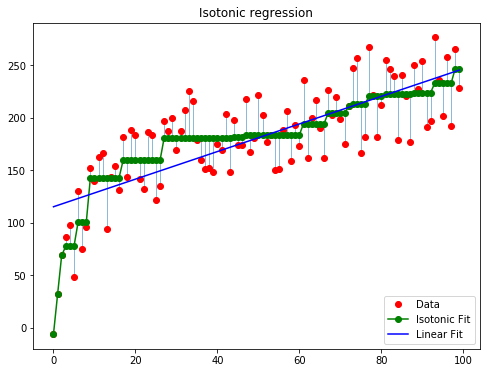

In [34]:
lr = LinearRegression()
lr.fit(x[:, np.newaxis], y)
# 对应着两条线，初始的y值和保序回归后的y_
segments = [[[i, y[i]], [i, y_[i]]] for i in range(n)]
# LineCollection可以在一个图中绘制多条线
lc = LineCollection(segments, zorder=0)
lc.set_linewidths(0.5 * np.ones(n))
fig = plt.figure(figsize=(8, 6))
# r.表示生成点图，如果不加.，那么就会将所有的红色点连成一条线
plt.plot(x, y, 'r.', markersize=12)
plt.plot(x, y_, 'g.-', markersize=12)
# 输出拟合结果
plt.plot(x, lr.predict(x[:, np.newaxis]), 'b-')
plt.gca().add_collection(lc)
plt.legend(('Data', 'Isotonic Fit', 'Linear Fit'), loc='lower right')
plt.title('Isotonic regression')
plt.show()

可以看到保序回归的拟合结果是分段函数，在拟合过程中，发现乱序序列后向后吸收元素取平均值，代表这段序列的拟合结果，所以会出现分段的现象。

## 2. 内核岭回归（Kernel ridge regression）

In [35]:
from __future__ import division
import time
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

SVR complexity and bandwidth selected and model fitted in 0.352 s
KRR complexity and bandwidth selected and model fitted in 0.139 s
Support vector ratio: 0.290
SVR prediction for 100000 inputs in 0.052 s
KRR prediction for 100000 inputs in 0.126 s


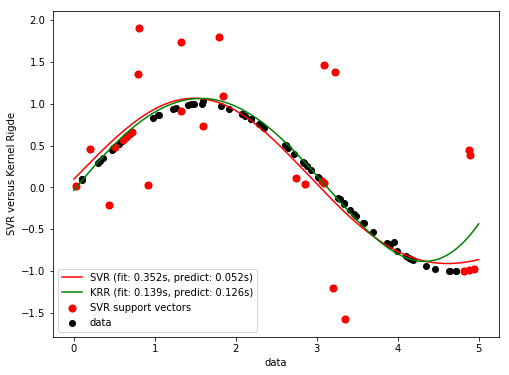

In [44]:
rng = np.random.RandomState(0)
# 生成样本数据
X = 5 * rng.rand(1000, 1)
y = np.sin(X).ravel()
# 给目标增加噪音，此处为带步长切片，每隔5个元素取一个，变成噪音
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))
X_plot = np.linspace(0, 5, 100000)[:, None]
train_size = 100   # 训练集大小
# GridSearchCV用于自动调参，遍历多种参数组合选取最优的。第一个参数为分类器，第二个为最优化的参数值
# cv是交叉验证参数，默认为None，这里使用5折交叉验证
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C":[1e0, 1e1, 1e2, 1e3],
                               "gamma":np.logspace(-2, 2, 5)})
kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

# t0为当前时间戳：1970年到现在的浮点秒数
t0 = time.time()
svr.fit(X[:train_size], y[:train_size])
# svr_fit为运行时间
svr_fit = time.time() - t0
print("SVR complexity and bandwidth selected and model fitted in %.3f s" % svr_fit)

t0 = time.time()
kr.fit(X[:train_size], y[:train_size])
kr_fit = time.time() - t0
print("KRR complexity and bandwidth selected and model fitted in %.3f s" % kr_fit)

# best_estimator_给出最优分类器，后面的support_方法是返回支持向量
# 除以train_size就是得到支持向量的比率
sv_ratio = svr.best_estimator_.support_.shape[0] / train_size
print("Support vector ratio: %.3f" % sv_ratio)

# 输出测试数据集运行时间
t0 = time.time()
y_svr = svr.predict(X_plot)
svr_predict = time.time() - t0
print("SVR prediction for %d inputs in %.3f s" % (X_plot.shape[0], svr_predict))

t0 = time.time()
y_kr = kr.predict(X_plot)
kr_predict = time.time() - t0
print("KRR prediction for %d inputs in %.3f s" % (X_plot.shape[0], kr_predict))

# 查看结果
sv_ind = svr.best_estimator_.support_
plt.figure(figsize=(8, 6))
# 支持向量为红色标记点
plt.scatter(X[sv_ind], y[sv_ind], c='r', s=50, label='SVR support vectors', zorder=2)
plt.scatter(X[:100], y[:100], c='k', label='data', zorder=1)
# plt.hold('on')
plt.plot(X_plot, y_svr, c='r', label='SVR (fit: %.3fs, predict: %.3fs)' % (svr_fit, svr_predict))
plt.plot(X_plot, y_kr, c='g', label='KRR (fit: %.3fs, predict: %.3fs)' % (kr_fit, kr_predict))
plt.xlabel('data')
plt.ylabel('SVR versus Kernel Rigde')
plt.legend()
plt.show()

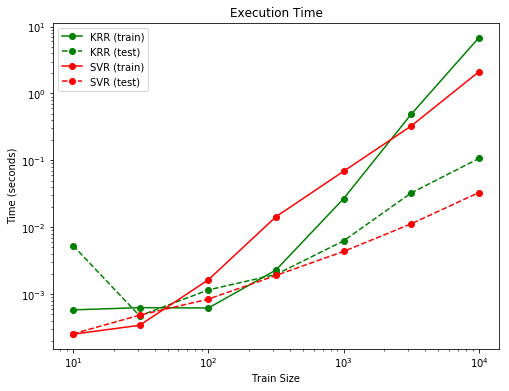

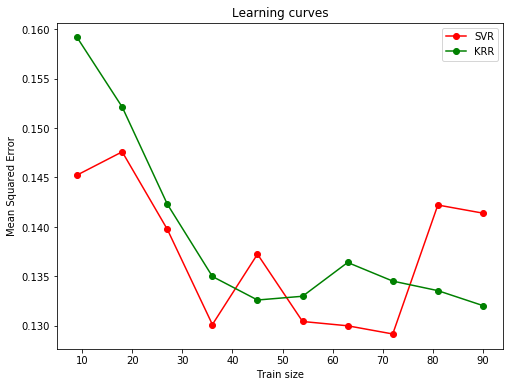

In [24]:
# 可视化训练和预测时间
plt.figure(figsize=(8, 6))
X = 5 * rng.rand(10000, 1)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))
# 生成7个点
sizes = np.logspace(1, 4, 7, dtype=np.int)
# sizes : array([   10,    31,   100,   316,  1000,  3162, 10000])
for name, estimator in {"KRR":KernelRidge(kernel='rbf', alpha=0.1, gamma=10),
                        "SVR":SVR(kernel='rbf', C=1e1, gamma=10)}.items():
    train_time = []
    test_time = []
    for train_test_size in sizes:
        # 训练时间
        t0 = time.time()
        estimator.fit(X[:train_test_size], y[:train_test_size])
        train_time.append(time.time() - t0)
        # 测试时间
        t0 = time.time()
        estimator.predict(X_plot[:1000])
        test_time.append(time.time() - t0)
    
    plt.plot(sizes, train_time, 'o-', color='r' if name == "SVR" else "g", label="%s (train)" % name)
    plt.plot(sizes, test_time, 'o--', color='r' if name == "SVR" else "g", label="%s (test)" % name)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Train Size")
    plt.ylabel("Time (seconds)")
    plt.title("Execution Time")
    plt.legend(loc='best')
    
plt.figure(figsize=(8, 6))

# 可视化学习曲线
svr = SVR(kernel='rbf', C=1e1, gamma=0.1)
kr = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.1)
train_sizes, train_scores_svr, test_scores_svr = \
    learning_curve(svr, X[:100], y[:100], train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)
train_sizes_abs, train_scores_kr, test_scores_kr = \
    learning_curve(kr, X[:100], y[:100], train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)

plt.plot(train_sizes, -test_scores_svr.mean(1), 'o-', color="r",
         label="SVR")
plt.plot(train_sizes, -test_scores_kr.mean(1), 'o-', color="g",
         label="KRR")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title('Learning curves')
plt.legend(loc="best")

plt.show()
